<a href="https://colab.research.google.com/github/andersonsam/CGU_2022_glacier_interpret/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
#clone in github repo 

!git clone https://github.com/andersonsam/CGU_2022_glacier_interpret #public repo


Cloning into 'CGU_2022_glacier_interpret'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [2]:
#also clone in github repo associated with "Evaluation and interpretation of convolutional long short-term memory networks for regional hydrological modelling"
#the trained CNN-LSTM models are in this repo

!git clone https://github.com/andersonsam/cnn_lstm_era #public repo

Cloning into 'cnn_lstm_era'...
remote: Enumerating objects: 802, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 802 (delta 11), reused 0 (delta 0), pack-reused 769
Receiving objects: 100% (802/802), 521.76 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (388/388), done.


In [3]:
dir_models = 'cnn_lstm_era/Models' #where to access trained models
dir_data = 'CGU_2022_glacier_interpret/Data/' #where to access data

In [4]:
#install the required dependencies
!pip install -r CGU_2022_glacier_interpret/requirements.txt

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 157 kB/s 
     |████████████████████████████████| 16.7 MB 462 kB/s 
     |████████████████████████████████| 6.3 MB 46.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
#import required libraries

# %tensorflow_version 2.x
# import tensorflow as tf
# import tensorflow.keras
# from tensorflow.keras import Model, Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
# from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
# import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
# import seaborn as sns

# from scipy import interpolate, optimize
# from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
# from sklearn.linear_model import LinearRegression
# from sklearn.decomposition import PCA

import pickle
# import os
# import time
from random import seed
# import imageio
# from datetime import datetime, date, timedelta
# from netCDF4 import Dataset
# from guppy import hpy
# from google.colab import drive

# from shapely.geometry import Point, Polygon
# from descartes import PolygonPatch
# from pyproj import Transformer
# import rasterio

#set random seed
seed = 0
np.random.seed(seed)

#for plotting
first_days_of_month = [0,31,59,90,120,151,181,212,243,273,304,334]
months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [6]:
# #mount google drive
# drive.mount('/content/drive')

In [7]:
#define functions

# def nse(y_obs, y_model):

#   """
#   Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

#   Use: NSE = nse(y_obs, y_model)

#   y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
#   """

#   if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
#     y_obs = np.array(y_obs)
#   if not isinstance(y_model, np.ndarray):
#     y_model = np.array(y_model)

#   y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
#   y_obs = y_obs.reshape((-1,1))

#   nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

#   return nse

def plot_prov_ax(prov, ax, linewidth = 1):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = 'CGU_2022_glacier_interpret/Data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if prov_poly.geom_type == 'Polygon': #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k', linewidth = linewidth)

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly.geoms)): 
        lonBorder_segment,latBorder_segment = prov_poly.geoms[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k', linewidth = linewidth)

# Prep data

In [8]:
#load data

prov = ['AB','BC'] #for plotting -- plot_prov_ax(prov = prov, ax = ax)

stationLat = pd.read_csv(dir_data + 'station_info.csv')['latitude'].values
stationLon = pd.read_csv(dir_data + 'station_info.csv')['longitude'].values
stationPG = pd.read_csv(dir_data + 'station_info.csv')['glacierization'].values
Nstations = len(stationLat)

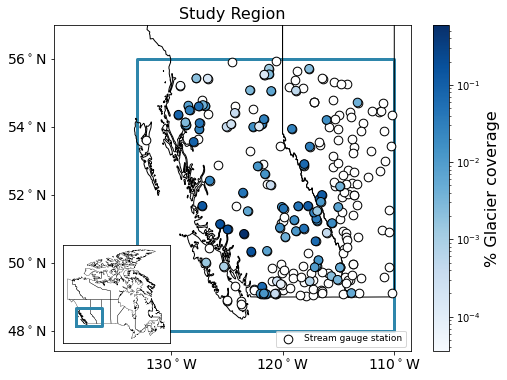

In [9]:
#visualize study region

saveIt = 0

fs = 16 #fontsize

nrows = 1
ncols = 1

fig, ax = plt.subplots(figsize = (8,6))

###### top left side: spatial map of stations, coloured by cluster to which they belong

### INSET
rgb_bb = np.array([46, 134, 171]) / 255
canada_east = -108
canada_west = -142
canada_north = 60
canada_south = 46
ax_inset = plt.axes([0,0,1,1], aspect = 'auto')
ip = InsetPosition(ax, [0.025,0.025,0.3,0.3])
ax_inset.set_axes_locator(ip)
plot_prov_ax(prov = 'all', ax = ax_inset, linewidth = 0.3)

#bounding box
x = [-133,-133,-110,-110,-133]
y = [48,56,56,48,48]
ax_inset.plot(x,y, color = rgb_bb, linewidth = 3)
ax.plot(x,y, color = rgb_bb, linewidth = 3)
ax_inset.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
###

plot_prov_ax(prov=prov, ax = ax)
ax.scatter(stationLon,stationLat, color='w', s = 75, linewidth = 1, edgeColor = 'k', zOrder = 3, label = 'Stream gauge station') #label
s = ax.scatter(stationLon[stationPG>0], stationLat[stationPG>0], c = stationPG[stationPG>0], s = 75, linewidth = 1, edgeColor = 'k', zOrder = 3, cmap = 'Blues', norm = matplotlib.colors.LogNorm())

ax.tick_params(labelsize = fs-2)
ax.set_title('Study Region', fontsize = fs)
ax.set_ylim(top = 57)

ax.legend(loc = 'lower right', fontsize = 9)

cb = plt.colorbar(s, ax = ax)
cb.ax.set_ylabel('% Glacier coverage', fontsize = fs)

#xticks
ax.set_xticks([-130,-120,-110])
ax.set_xticklabels([-130,-120,-110])
xtls = [str(int(item.get_text()[1::])) + '$^\circ$W' for item in ax.get_xticklabels()]
ax.set_xticklabels(xtls)

#yticks
ax.set_yticks(np.arange(48,57,2))
ax.set_yticklabels(np.arange(48,57,2))
ytls = [item.get_text() + '$^\circ$N' for item in ax.get_yticklabels()]
ax.set_yticklabels(ytls)

if saveIt:
  plt.savefig('CGU_study_region.png', bbox_inches = 'tight', dpi = 300)

plt.show()

# Cell state

In [10]:
# credit for code: sigmoid, LSTMlayer, get_LSTM_states
# Yumi's Blog
# https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html

def sigmoid(x):

  """ 
  returns the sigmoid activation of an input x

  z = sigmoid(x)
  """

  return(1./(1.+np.exp(-x)))

def LSTMlayer(weight,x_t,h_tm1,c_tm1):

    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''

    warr, uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i = sigmoid(s_t[:,:hunit])
    f = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

def get_LSTM_states(model,layer_num,xs):

  weightLSTMs = []
  for layer in model.layers:
    if "LSTM" in str(layer):
      weightLSTMs.append(layer.get_weights())

  if layer_num == 0:

    weightLSTM = weightLSTMs[layer_num]
    warr, uarr, barr = weightLSTM

    hunits = uarr.shape[0]

    c_tm1 = np.array([0]*hunits).reshape(1,hunits)
    h_tm1 = np.array([0]*hunits).reshape(1,hunits)

    h_t = []
    c_t = []

    for i in range(len(xs)):
      x_t = xs[i].reshape(1,32)
      h_tm1, c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
      h_t.append(np.squeeze(h_tm1))
      c_t.append(np.squeeze(c_tm1))

  return c_t, h_t

In [11]:
with open('xtest_day (2).pickle', 'rb') as f:
  x_test_day = pickle.load(f)

FileNotFoundError: ignored

In [12]:
#USE RHO, P THRESHOLDS; load all models

with open(dir_data + 'xtest_day.pickle', 'rb') as f:
  x_test_day = pickle.load(f)

N_models = 10 #number of models
N_states_per_model = 80 #number of cell states per model
cts = np.zeros((365,N_states_per_model*N_models)) #all cell states from all models
cts_top = np.zeros((365,106)) #top cell states from all models
rho_all = [] #correlation
rho_top = []
p_value_top = []
p_value_all = []

nn = 0 #counts number of significantly-correlated cell states

for ii in range(N_models): #for each model

  cluster_seasonal = 0 #only investigate central cluster, since this is where most glaciers are
  model_name = 'model_fine_' + str(ii) + '_cluster_' + str(cluster_seasonal) + '.h5'
  model_fine = tf.keras.models.load_model(dir_models + '/' + model_name)

  #CNN part
  model_CNN = Sequential()
  for kk in range(8):
    model_CNN.add(model_fine.layers[kk])

  #LSTM part
  model_LSTM = Sequential()
  model_LSTM.add(tf.keras.layers.InputLayer(input_shape = (365,32)))
  model_LSTM.add(model_fine.layers[9])

  #dense weights
  dense_layer = model_fine.layers[-1]
  weights, bias = dense_layer.get_weights()

  #basin values
  inds_cluster = np.squeeze(np.argwhere(seasonal_clustering.labels_==cluster_seasonal))
  stationPG_cluster = stationPG[inds_cluster]

  # compute cell states
  yy = 1 #number of years
  day_num = 365*yy #cell state values are the 365 days preceding this day
  layer_num = 0

  xs = np.array(model_CNN.predict(tf.expand_dims(x_test[day_num], axis = 0)))[0]
  ct, ht = get_LSTM_states(model = model_LSTM, layer_num = layer_num, xs = xs)
  ct = np.array(ct)
  ht = np.array(ht)
  cts[:, ii*N_states_per_model : (ii+1)*N_states_per_model] = ct

  # dw_dG = np.zeros(N_states_per_model) #gradient of weights w.r.t. glacier coverage
  rho = np.zeros(N_states_per_model) #correlation coefficient between weights and glacier coverage
  p_value = np.zeros(N_states_per_model) #p-value of correlation between weights and glacier coverage
  for ww in range(N_states_per_model): #for each state
    X = stationPG_cluster.reshape(-1,1)
    y = weights[ww,:].reshape(-1,1)
    rho[ww], p_value[ww] = pearsonr(x = X.squeeze(), y = y.squeeze())
    rho_all.append(rho[ww])
    p_value_all.append(p_value[ww])

  # sorted_gradients = np.argsort(np.abs(dw_dG))
  sorted_rho = np.argsort(np.abs(rho))
  sorted_rho_vals = np.sort(np.abs(rho))
  sorted_p_vals = p_value[sorted_rho]
  N_top_this_model = len(np.argwhere(sorted_p_vals<0.05))

  for kk in range(N_top_this_model):

    #now: if a state is strongly negatively correlated, multiply the cell state by -1 so that we interpret it as "strongly positively related to glacier coverage"
    factor = 1
    if rho[sorted_rho[-kk-1]]<0:
      factor = -1

    cts_top[:,nn] = factor*ct[:,sorted_rho[-kk-1]]
    rho_top.append(sorted_rho_vals[-kk-1])
    p_value_top.append(sorted_p_vals[-kk-1])
    nn+=1

UnpicklingError: ignored

In [ ]:
#review 
N_top = len(p_value_top)

print('Number of significantly correlated cell states: \n\t',N_top)
print('Min, Mean, Max correlation \n\t',np.round(np.min(rho_top),decimals = 2), np.round(np.mean(rho_top),decimals = 2), np.round(np.max(rho_top),decimals = 2))
print('Min, Mean, Max p-values: \n\t',np.round(np.min(p_value_top),decimals = 3), np.round(np.mean(p_value_top),decimals = 3), np.round(np.max(p_value_top),decimals = 3))


In [ ]:
#prep to cluster the "glacially relevant" states 

cluster_input = cts_top.T
cluster_input -= np.expand_dims(np.mean(cluster_input, axis = 1), axis = 1)
cluster_input /= np.expand_dims(np.std(cluster_input, axis = 1), axis = 1)

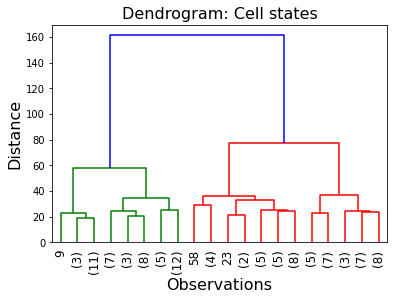

In [ ]:
#make dendrogram to decide number of clusters of cell states 

saveIt = 0

fig, ax = plt.subplots()
linked = linkage(cluster_input, 'ward')
dendrogram(linked, orientation = 'top', distance_sort = 'descending', truncate_mode = 'lastp', p = 20, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

ax.set_title('Dendrogram: Cell states', fontsize = fs)
ax.set_xlabel('Observations', fontsize = fs)
ax.set_ylabel('Distance', fontsize = fs)

if saveIt:
  plt.savefig('dendrogram_cell_states.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
#cluster states

n_clusters = 2
model = AgglomerativeClustering(n_clusters = n_clusters).fit(cluster_input)
labels = model.labels_

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(labels == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

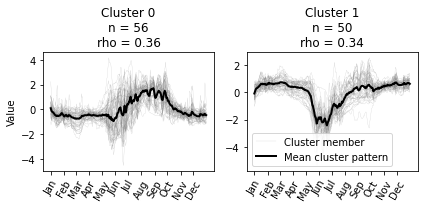

In [ ]:
#cluster patterns

saveIt = 0

nrows = 1
ncols = n_clusters

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (3*ncols, 3*nrows))

for cluster, ax in enumerate(axes.flatten()):

  cluster_inds = np.argwhere(labels==cluster).squeeze()
  rho_mean = np.mean(np.asarray(rho_top)[cluster_inds])
  ax.plot(cluster_input[cluster_inds,:].T, linewidth = 0.2, alpha = 0.5, color = 'gray')
  ax.plot(cluster_input[cluster_inds[0],:], linewidth = 0.2, alpha = 0.5, color = 'gray', label = 'Cluster member')
  ax.plot(cluster_patterns[cluster,:], 'k', linewidth = 2, label = 'Mean cluster pattern')
  ax.set_title('Cluster ' + str(cluster) + '\nn = ' + str(len(cluster_inds)) + '\nrho = ' + str(np.round(rho_mean,decimals = 2)))
  ax.set_xticks(first_days_of_month)
  ax.set_xticklabels(months_str, rotation = 60)
  if cluster == 0:
    ax.set_ylabel('Value')

ax.legend()

plt.tight_layout()

if saveIt:
  plt.savefig('cell_state_clusters.png', dpi = 300, bbox_inches = 'tight')

plt.show()

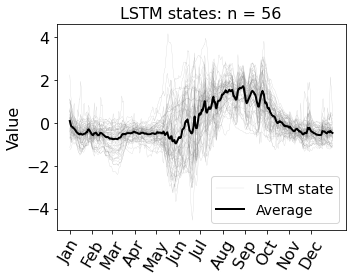

In [ ]:
#cluster members of just 'glacier-runnoff-like' cluster

saveIt = 1

cluster = 0

nrows = 1
ncols = 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (5*ncols, 4*nrows))

cluster_inds = np.argwhere(labels==cluster).squeeze()
rho_mean = np.mean(np.asarray(rho_top)[cluster_inds])
ax.plot(cluster_input[cluster_inds,:].T, linewidth = 0.2, alpha = 0.5, color = 'gray')
ax.plot(cluster_input[cluster_inds[0],:], linewidth = 0.2, alpha = 0.5, color = 'gray', label = 'LSTM state')
ax.plot(cluster_patterns[cluster,:], 'k', linewidth = 2, label = 'Average')
ax.set_title('LSTM states: n = ' + str(len(cluster_inds)), fontsize = fs)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 60, fontsize = fs)
ax.set_ylabel('Value', fontsize = fs)
ax.tick_params(labelsize = fs)

ax.legend(fontsize = fs - 2)

plt.tight_layout()

if saveIt:
  plt.savefig('cell_states_glacial_cluster.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [ ]:
#select the cluster pattern of interest to further investigate

cluster_pattern = cluster_patterns[0]

In [ ]:
#smooth and calculate residuals; window: centered

window = 30

Tmax_cluster_smooth = pd.Series(Tmax_cluster).rolling(window = window, min_periods = 1, center = True).mean().values
Tmin_cluster_smooth = pd.Series(Tmin_cluster).rolling(window = window, min_periods = 1, center = True).mean().values
Tmean_cluster_smooth = pd.Series(Tmean_cluster).rolling(window = window, min_periods = 1, center = True).mean().values

Tmax_cluster_res = Tmax_cluster - Tmax_cluster_smooth
Tmin_cluster_res = Tmin_cluster - Tmin_cluster_smooth
Tmean_cluster_res = Tmean_cluster - Tmean_cluster_smooth

cluster_pattern_smooth = pd.Series(cluster_pattern).rolling(window = window, min_periods = 1, center = True).mean().values
cluster_pattern_res = cluster_pattern - cluster_pattern_smooth

#find lag that most highly correlates cell states with positive temperature
for lag in range(0,6):
  if lag == 0:
    var1 = Tmean_cluster_res
    var2 = cluster_pattern_res
  else:
    var1 = Tmean_cluster_res[:-lag]
    var2 = cluster_pattern_res[lag:]

  print('Correlation when lag = ',lag,'day: ',np.round(np.corrcoef(var1,var2)[0,1], decimals = 2))

Correlation when lag =  0 day:  0.11
Correlation when lag =  1 day:  0.46
Correlation when lag =  2 day:  0.55
Correlation when lag =  3 day:  0.47
Correlation when lag =  4 day:  0.33
Correlation when lag =  5 day:  0.19


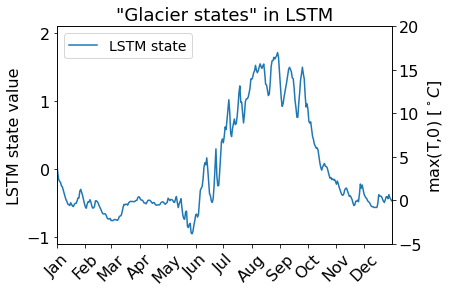

In [ ]:
#CGU presentation figures

saveIt = 0

cmap = matplotlib.colors.ListedColormap(np.array([255,255,255])/255)
bounds = [0,1,2,3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

daily = 1
seasonal = 0
shade = 0

T_daily = 0
T_seasonal = 0
T_shade = 0

fs = 16

x1 = cluster_pattern_smooth
x2 = cluster_pattern_res
x3 = x1 + x2
x4 = cluster_pattern

xim = np.zeros((1,1))

fig, ax = plt.subplots()#figsize = (20,4))

##### LSTM STATES

if daily:
  ax.plot(x3, zorder = 0, label = 'LSTM state')
if shade:
  ax.imshow(xim, extent = [0,365,-1.1,1.8], alpha = 0.7, aspect = 'auto', cmap = cmap)#'Blues')
if seasonal:
  ax.plot(x1, label = 'LSTM state')#, 'k')

ax.set_xlim(left = 0, right = 364)
ax.set_ylim(bottom = -1.1, top = 2.1)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 45, fontsize = fs)
ax.tick_params(labelsize = fs)
ax.set_ylabel('LSTM state value', fontsize = fs)
ax.set_title('"Glacier states" in LSTM', fontsize = fs+2)

##### POSITIVE TEMPERATURES

var = Tmean_cluster - 273
var_seas = Tmean_cluster_smooth - 273
var_res = Tmean_cluster_res - 273

# if T_daily or T_seasonal or T_shade:

ax2 = ax.twinx()

if T_daily:
  ax2.plot(var, color = '#ff7f0e', label = 'max(T,0)')
if T_seasonal:
  ax2.plot(var_seas, color = '#ff7f0e', label = 'max(T,0)')

ax2.set_ylim(bottom = -4, top = 18)
ax2.set_yticks(ax2.get_yticks()[::2])
ax2.tick_params(labelsize = fs)
ax2.set_ylabel('max(T,0) [$^\circ C$]', fontsize = fs)

#one legend with labels from both ax and ax2
h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax.legend(handles, labels, fontsize = fs-2)

if saveIt:

  filename = 'LSTM_state_day_season_shade_Tday_Tseason_Tres__' + str(daily) + '_' + str(seasonal) + '_' + str(shade) + '_' + str(T_daily) + '_' + str(T_seasonal) + '.png'
  plt.savefig(filename, dpi = 300, bbox_inches = 'tight')

plt.show()


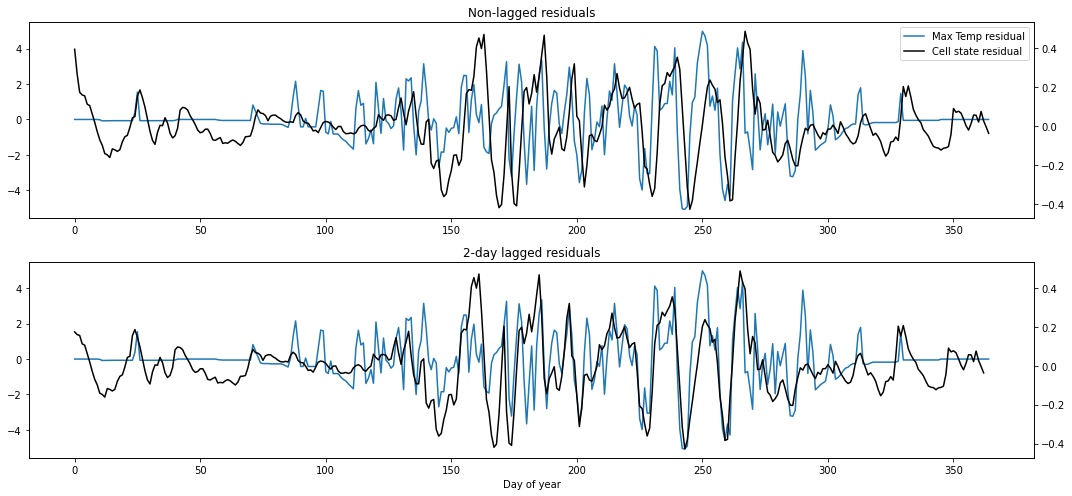

In [ ]:
#residuals

saveIt = 0

lag = 2

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15,7))

var = Tmean_cluster_res

ax[0].plot(var, label = 'Max Temp residual')
ax2 = ax[0].twinx()
ax2.plot(cluster_pattern_res,'k', label = 'Cell state residual')
ax[0].set_title('Non-lagged residuals')

ax[1].plot(var)
ax2 = ax[1].twinx()
ax2.plot(cluster_pattern_res[lag:],'k', label = 'Cell state residual')
ax[1].set_title(str(lag)+'-day lagged residuals')
ax[1].set_xlabel('Day of year')
plt.tight_layout()

#one legend with labels from both ax and ax2
h, l = ax[0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labels = l+l2
handles = h+h2
ax[0].legend(handles, labels)

if saveIt:
  plt.savefig('residuals.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
#calculate rolling windows of correlation between cell state and temperature (residuals)

window = 60
lag = 2

starts = range(0,365-window-lag) #starting days from which to calculate 60-day correlation
corr_max = np.zeros(len(starts)) #correlations of max temp
corr_min = np.zeros(len(starts)) #correlations of min temp
corr_mean = np.zeros(len(starts))#correlations of precip

p_max = np.zeros(len(starts)) #p-values of max temp
p_min = np.zeros(len(starts)) #p-values of min temp
p_mean = np.zeros(len(starts))#p-values of precip

for kk, start in enumerate(starts):

  var = Tmax_cluster_res
  X = var[start:start+window]
  y = cluster_pattern_res[start+lag:start+lag+window]
  corr_max[kk], p_max[kk] = pearsonr(x = X, y = y)

  var = Tmin_cluster_res
  X = var[start:start+window]
  y = cluster_pattern_res[start+lag:start+lag+window]
  corr_min[kk], p_min[kk] = pearsonr(x = X, y = y)

  var = Tmean_cluster_res
  X = var[start:start+window]
  y = cluster_pattern_res[start+lag:start+lag+window]
  corr_mean[kk], p_mean[kk] = pearsonr(x = X, y = y)

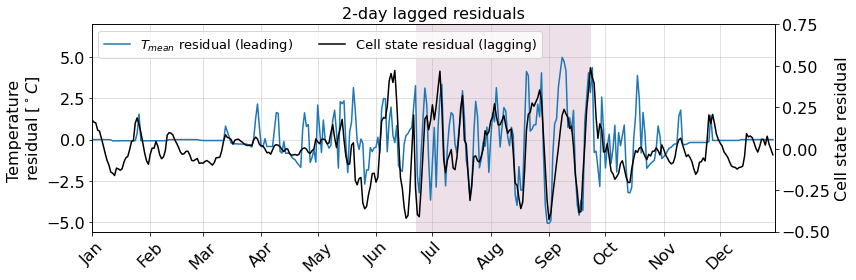

In [ ]:
#CGU figure of cell state panels

saveIt = 0

state = 1
T = 1
lag = 2
highlight = 1

fs = 16

nrows = 1
ncols = 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12*ncols, 4*nrows))

########## RESIDUALS ##########

if lag == 0:
  var1 = Tmean_cluster_res
  var2 = cluster_pattern_res
else:
  var1 = Tmean_cluster_res[:-lag]
  var2 = cluster_pattern_res[lag:]

ax.plot(var1, label = '$T_{mean}$ residual (leading)')
if lag == 0:
  ax.set_title('Residuals', fontsize = fs)
else:
  ax.set_title(str(lag) + '-day lagged residuals', fontsize = fs)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 45)#, ha = 'right')
ax.tick_params(labelsize = fs)
ax.set_ylabel('Temperature \nresidual [$^\circ C$]', fontsize = fs)
ax.grid(alpha = 0.5)
ax.set_xlim(left = 0, right = 363)
ax.set_ylim(top = np.max(var1)+2)


ax2 = ax.twinx()
if T:
  ax2.plot(var2,'k', label = 'Cell state residual (lagging)')
ax2.tick_params(labelsize = fs)
ax2.set_xticks(first_days_of_month)
ax2.set_ylabel('Cell state residual', fontsize = fs)
ax2.set_xlim(left = 0, right = 363)
ax2.set_ylim(bottom = -0.5, top = 0.75)#top = np.max(var2)+0.25)

if highlight:
  rgbs_corr = np.array(
      [[255,255,255],
      [147, 47, 109]]
  ) / 255
  cmap = matplotlib.colors.ListedColormap(rgbs_corr)
  bounds = [-0.5,0.5]
  norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
  extent = [0,363,np.min(var1)-1, np.max(var1)+4]
  ii = np.zeros((1,363))
  ii[0,172:265] = 1
  ax.imshow(ii, cmap = cmap, extent = extent, aspect = 'auto', alpha = 0.15, zorder = 0)

#one legend with labels from both ax and ax2
if T:
  h, l = ax.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()
  labels = l+l2
  handles = h+h2
  ax.legend(handles, labels, fontsize = fs-3, loc = 'upper left', ncol = 2)
else: 
  ax.legend(fontsize = fs, loc = 'upper left')


plt.tight_layout()

if saveIt:
  filename = 'residuals_state_T_lag_highlight__' + str(state) + '_' + str(T) + '_' + str(lag) + '_' + str(highlight) + '.png'
  plt.savefig(filename, dpi = 300, bbox_inches = 'tight')

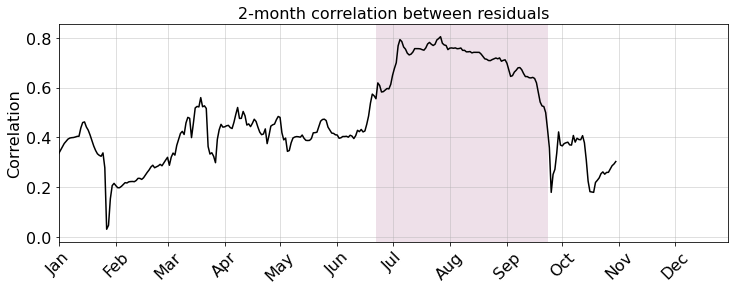

In [ ]:
#CGU figure of cell state panels

saveIt = 0

fs = 16

nrows = 1
ncols = 1

fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12*ncols, 4*nrows))

########## CORR ##########

var1 = corr_mean

ax.plot(var1,'k', label = 'Correlation')

rgbs_corr = np.array(
    [[255,255,255],
     [147, 47, 109]]
) / 255
cmap = matplotlib.colors.ListedColormap(rgbs_corr)
bounds = [-0.5,0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
extent = [0,363,np.min(var1)-0.05, np.max(var1)+0.05]
ii = np.zeros((1,363))
ii[0,172:265] = 1
ax.imshow(ii, cmap = cmap, extent = extent, aspect = 'auto', alpha = 0.15, zorder = 0)

ax.set_xlim(left = 0, right = 363)
ax.set_xticks(first_days_of_month)
ax.set_xticklabels(months_str, rotation = 45)#, ha = 'right')
ax.tick_params(labelsize = fs)
ax2.tick_params(labelsize = fs)
ax.set_xticks(first_days_of_month)
ax.set_ylabel('Correlation', fontsize = fs)
ax.set_title('2-month correlation between residuals', fontsize = fs)
ax.grid(alpha = 0.5)
# ax.text(0.48,0.11, 'Changes in $T_{mean}$ map \nto changes in lagged \ncell state in summer \nand fall', transform = ax.transAxes, fontsize = fs-4.5)

if saveIt:
  filename = 'correlation_state_temp_residuals.png'
  plt.savefig(filename, dpi = 300, bbox_inches = 'tight')

In [ ]:
#correlation of two periods

june15 = 166
sept15 = 258

corr_meltseason = np.mean(corr_mean[june15:sept15])
corr_nonmelt = np.mean(np.concatenate([corr_mean[:june15],corr_mean[sept15:]]))

print(corr_meltseason, corr_nonmelt)

0.7008912422099434 0.37225682604978966
